In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nptdms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nptdms: filename=nptdms-1.10.0-py3-none-any.whl size=108456 sha256=48a07ccf575f6d1af726ce24efe167cfbb1d22a97100e3fed3a924699504a21f
  Stored in directory: /root/.cache/pip/wheels/1b/4b/17/21e8b03b37ea51ce7ec9f5570cdf0decca93f537d61c06880f
Successfully built nptdms


## 중단 조건 미만 데이터셋 $T_{failure}$ 처리를 위한 선형 회귀

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from nptdms import TdmsFile
import pandas as pd

파일 불러오기

In [6]:
def load_tdms_file(file_path):
    tdms_file = TdmsFile.read(file_path)

    group_name_vibration = tdms_file.groups()[0].name
    group_name_operation = tdms_file.groups()[1].name

    vib_channels = tdms_file[group_name_vibration].channels()
    vib_data = {ch.name.strip(): ch.data for ch in vib_channels}

    operation_channels = tdms_file[group_name_operation].channels()
    operation_data = {ch.name.strip(): ch.data for ch in operation_channels}

    return vib_data, operation_data

In [8]:
# 폴더 및 파일 탐색
train_root = "/content/drive/MyDrive/KSPHM-data-challenge/Train Set"  # Colab에서 압축 푼 경로에 맞게 수정
target_folders = ["Train2", "Train3", "Train6"]

summary = {}

for folder in target_folders:
    folder_path = os.path.join(train_root, folder)
    tdms_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tdms")])

    records = []

    for idx, tdms_file in enumerate(tdms_files):
        file_path = os.path.join(folder_path, tdms_file)
        _, operation_data = load_tdms_file(file_path)

        # 시간 단위 index (10분 간격)
        time_sec = idx * 600

        record = {
            "time_sec": time_sec,
            "TC SP Front[℃]": operation_data["TC SP Front[℃]"][0],
            "TC SP Rear[℃]": operation_data["TC SP Rear[℃]"][0],
            "Torque[Nm]": operation_data["Torque[Nm]"][0],
        }
        records.append(record)

    df = pd.DataFrame(records)
    summary[folder] = df

# 결과 확인
for folder in summary:
    print(f"{folder} 데이터:")
    print(summary[folder].tail(5))  # 마지막 5개만 출력
    print()

Train2 데이터:
     time_sec  TC SP Front[℃]  TC SP Rear[℃]  Torque[Nm]
144     86400        124.6276       110.6115   -7.380063
145     87000        135.7751       110.9978  -10.629135
146     87600        165.0791       111.5146   -6.945480
147     88200        165.0792       112.2997   -6.304887
148     88800        199.1152       113.2843   -5.401386

Train3 데이터:
     time_sec  TC SP Front[℃]  TC SP Rear[℃]  Torque[Nm]
107     64200        158.2614       122.9847   -6.361785
108     64800        182.3090       124.7217  -11.953485
109     65400        178.7387       126.6482   -6.938613
110     66000        179.4747       128.1256  -10.586952
111     66600        199.8186       128.4092  -10.795905

Train6 데이터:
    time_sec  TC SP Front[℃]  TC SP Rear[℃]  Torque[Nm]
44     26400        105.2946       175.9277   -7.403607
45     27000        107.8196       184.3371   -6.553080
46     27600        109.5662       184.8808  -11.127483
47     28200        111.3548       184.8431  -10.29657

선형 회귀 모델 정의

In [13]:
def estimate_rul_from_temp_time_based(temp_values, start_index, interval_sec=600, file_id="Sample"):
    n = len(temp_values)

    # time(sec) 기준 x 값 생성
    x = np.arange(start_index, start_index + n) * interval_sec  # 시간 단위로 변환
    y = np.array(temp_values)

    # reshape for sklearn
    x_reshaped = x.reshape(-1, 1)

    # linear regression
    model = LinearRegression().fit(x_reshaped, y)
    m = model.coef_[0]
    c = model.intercept_

    if m <= 0:
        print(f"[{file_id}] Warning: Temperature is not increasing (slope ≤ 0).")
        return None, None

    # estimate failure time(sec)
    estimated_failure_time_sec = (200 - c) / m
    rul_seconds = estimated_failure_time_sec - x[-1]  # 현재 시점부터의 RUL(sec)

    if estimated_failure_time_sec < x[-1] or rul_seconds < 0:
        print(f"[{file_id}] Warning: Predicted failure is before current time. Invalid regression.")
        return None, None

    return estimated_failure_time_sec, rul_seconds

In [15]:
targets = {
    "Train2": "TC SP Front[℃]",
    "Train3": "TC SP Front[℃]",
    "Train6": "TC SP Rear[℃]"
}

for train_id, col in targets.items():
    df = summary[train_id]
    for n in [3, 5]:  # 마지막 3개와 5개 모두 시도
        temp_values = df[col].values[-n:]
        start_index = df.index[-n]  # 인덱스가 이미 TDMS 인덱스이므로 그대로 사용
        print(f"{train_id} | {col} | last {n} points")
        est_fail_time, rul_sec = estimate_rul_from_temp_time_based(
            temp_values,
            start_index,
            interval_sec=600,
            file_id=f"{train_id}_{col}_last{n}"
        )
        if est_fail_time is not None:
            print(f"Estimated failure time (sec): {est_fail_time:.1f}")
            print(f"Estimated RUL (sec): {rul_sec:.1f}")
        else:
            print("Estimation invalid or failed.")
        print()


Train2 | TC SP Front[℃] | last 3 points
Estimated failure time (sec): 89031.2
Estimated RUL (sec): 231.2

Train2 | TC SP Front[℃] | last 5 points
Estimated failure time (sec): 89015.7
Estimated RUL (sec): 215.7

Train3 | TC SP Front[℃] | last 3 points
Estimated failure time (sec): 66796.4
Estimated RUL (sec): 196.4

Train3 | TC SP Front[℃] | last 5 points
Estimated failure time (sec): 66915.7
Estimated RUL (sec): 315.7

Train6 | TC SP Rear[℃] | last 3 points
Estimated failure time (sec): 29075.8
Estimated RUL (sec): 275.8

Train6 | TC SP Rear[℃] | last 5 points
Estimated failure time (sec): 29414.9
Estimated RUL (sec): 614.9



3 points vs 5 points

R²가 더 높고, 시각화 결과도 깔끔하며, RUL 값이 합리적인 쪽을 최종 선택

In [11]:
from sklearn.metrics import r2_score

def estimate_rul_from_temp_time_based(temp_values, start_index, interval_sec=600, plot=False, file_id="Sample"):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression

    n = len(temp_values)
    x = np.arange(start_index, start_index + n) * interval_sec
    y = np.array(temp_values)
    x_reshaped = x.reshape(-1, 1)

    model = LinearRegression().fit(x_reshaped, y)
    y_pred = model.predict(x_reshaped)
    r2 = r2_score(y, y_pred)

    m = model.coef_[0]
    c = model.intercept_

    if m <= 0:
        print(f"[{file_id}] Warning: Temperature is not increasing (slope ≤ 0).")
        return None, None

    estimated_failure_time_sec = (200 - c) / m
    rul_seconds = estimated_failure_time_sec - x[-1]

    if plot:
        x_pred = np.linspace(x[0], estimated_failure_time_sec, 100)
        y_pred_line = model.predict(x_pred.reshape(-1, 1))

        plt.figure(figsize=(6, 4))
        plt.plot(x, y, 'bo-', label="Observed Temp")
        plt.plot(x_pred, y_pred_line, 'r--', label=f"Linear Fit (R²={r2:.3f})")
        plt.axhline(200, color='gray', linestyle='--', label="200℃ threshold")
        plt.axvline(estimated_failure_time_sec, color='green', linestyle='--', label=f"Est. Failure @ {estimated_failure_time_sec:.0f} sec")
        plt.title(f"Linear Regression for {file_id}")
        plt.xlabel("Time (sec)")
        plt.ylabel("Temperature (℃)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if estimated_failure_time_sec < x[-1] or rul_seconds < 0:
        print(f"[{file_id}] Warning: Predicted failure is before current time. Invalid regression.")
        return None, None

    print(f"[{file_id}] R² score: {r2:.4f}")
    return estimated_failure_time_sec, rul_seconds

Train2 | TC SP Front[℃] | last 3 points


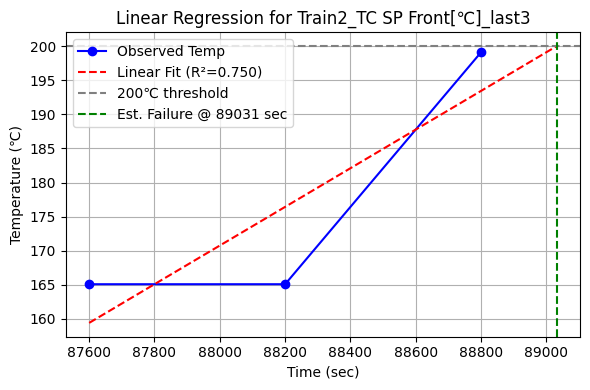

[Train2_TC SP Front[℃]_last3] R² score: 0.7500
Estimated failure time (sec): 89031.2
Estimated RUL (sec): 231.2

Train2 | TC SP Front[℃] | last 5 points


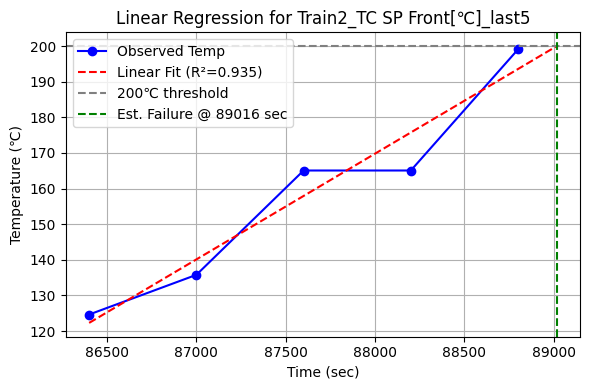

[Train2_TC SP Front[℃]_last5] R² score: 0.9353
Estimated failure time (sec): 89015.7
Estimated RUL (sec): 215.7

Train3 | TC SP Front[℃] | last 3 points


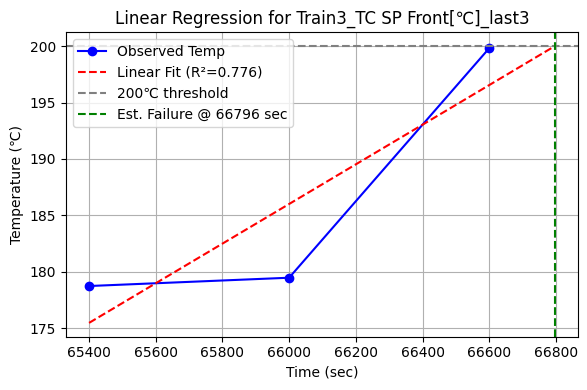

[Train3_TC SP Front[℃]_last3] R² score: 0.7762
Estimated failure time (sec): 66796.4
Estimated RUL (sec): 196.4

Train3 | TC SP Front[℃] | last 5 points


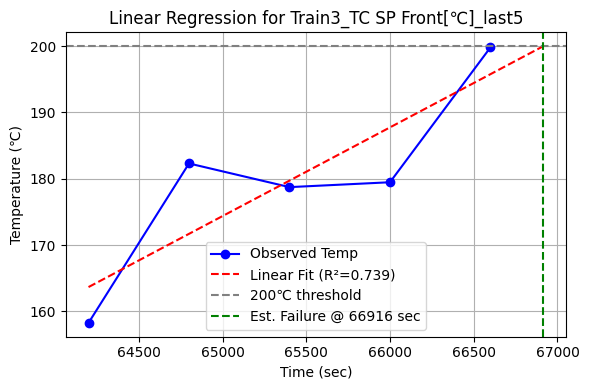

[Train3_TC SP Front[℃]_last5] R² score: 0.7390
Estimated failure time (sec): 66915.7
Estimated RUL (sec): 315.7

Train6 | TC SP Rear[℃] | last 3 points


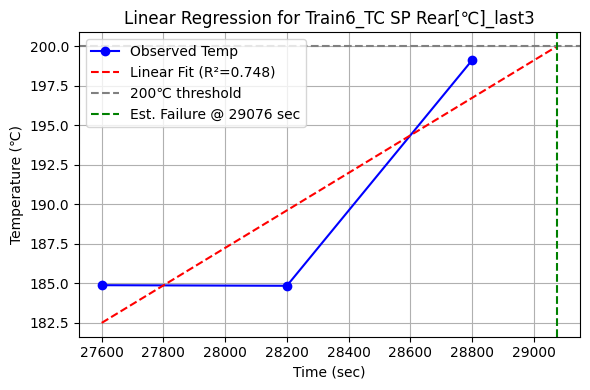

[Train6_TC SP Rear[℃]_last3] R² score: 0.7480
Estimated failure time (sec): 29075.8
Estimated RUL (sec): 275.8

Train6 | TC SP Rear[℃] | last 5 points


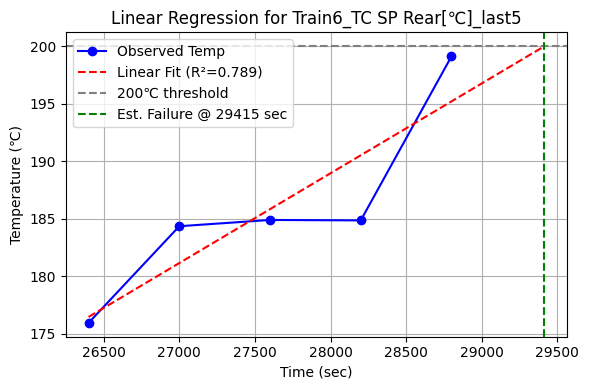

[Train6_TC SP Rear[℃]_last5] R² score: 0.7887
Estimated failure time (sec): 29414.9
Estimated RUL (sec): 614.9



In [12]:
targets = {
    "Train2": "TC SP Front[℃]",
    "Train3": "TC SP Front[℃]",
    "Train6": "TC SP Rear[℃]"
}

for train_id, col in targets.items():
    df = summary[train_id]
    for n in [3, 5]:  # 마지막 3개와 5개 모두 시도
        temp_values = df[col].values[-n:]
        start_index = df.index[-n]  # 인덱스가 이미 TDMS 인덱스이므로 그대로 사용
        print(f"{train_id} | {col} | last {n} points")
        est_fail_time, rul_sec = estimate_rul_from_temp_time_based(
            temp_values,
            start_index,
            interval_sec=600,
            plot=True,
            file_id=f"{train_id}_{col}_last{n}"
        )
        if est_fail_time is not None:
            print(f"Estimated failure time (sec): {est_fail_time:.1f}")
            print(f"Estimated RUL (sec): {rul_sec:.1f}")
        else:
            print("Estimation invalid or failed.")
        print()

## 모듈화

In [21]:
from sklearn.linear_model import LinearRegression
import numpy as np

선형 회귀 함수

In [22]:
def estimate_rul_from_temp_time_based(temp_values, start_index, interval_sec=600, file_id="Sample"):
    n = len(temp_values)
    x = np.arange(start_index, start_index + n) * interval_sec
    y = np.array(temp_values)

    x_reshaped = x.reshape(-1, 1)
    model = LinearRegression().fit(x_reshaped, y)
    m = model.coef_[0]
    c = model.intercept_

    if m <= 0:
        print(f"[{file_id}] Warning: Temperature is not increasing (slope ≤ 0).")
        return None, None

    estimated_failure_time_sec = (200 - c) / m
    rul_seconds = estimated_failure_time_sec - x[-1]

    if estimated_failure_time_sec < x[-1] or rul_seconds < 0:
        print(f"[{file_id}] Warning: Predicted failure is before current time. Invalid regression.")
        return None, None

    return estimated_failure_time_sec, rul_seconds

입력 함수

In [23]:
targets = {
    "Train2": ("TC SP Front[℃]", "TC SP Rear[℃]"),
    "Train3": ("TC SP Front[℃]", "TC SP Rear[℃]"),
    "Train6": ("TC SP Front[℃]", "TC SP Rear[℃]")
}

def choose_temp_column_closer_to_200(df, front_col, rear_col):
    # 마지막 측정값 기준으로 200도와의 절대 차이 비교 후 Front, Rear 선택
    front_diff = abs(df[front_col].iloc[-1] - 200)
    rear_diff = abs(df[rear_col].iloc[-1] - 200)
    if front_diff <= rear_diff:
        return front_col
    else:
        return rear_col

def select_best_rul_with_temp_choice(df, train_id, threshold_r2=0.85, interval_sec=600):
    front_col, rear_col = targets[train_id]
    target_col = choose_temp_column_closer_to_200(df, front_col, rear_col)

    results = []

    for n in [3, 5]:
        temp_values = df[target_col].values[-n:]
        start_index = df.index[-n]
        x = np.arange(start_index, start_index + n) * interval_sec
        y = np.array(temp_values)

        model = LinearRegression().fit(x.reshape(-1, 1), y)
        r2 = model.score(x.reshape(-1, 1), y)

        est_time, rul = estimate_rul_from_temp_time_based(
            temp_values=temp_values,
            start_index=start_index,
            interval_sec=interval_sec,
            file_id=f"{train_id}_{target_col}_last{n}"
        )

        if est_time is not None and rul is not None:
            results.append((r2, est_time, rul, n))

    # 우선 R²가 threshold 이상인 것 중 R²가 높은 것 선택
    filtered = [res for res in results if res[0] >= threshold_r2]

    if filtered:
        best = max(filtered, key=lambda x: x[0])
    elif results:
        best = max(results, key=lambda x: x[0])
    else:
        print(f"[{train_id}] No valid regression results.")
        return None, None, None

    r2, est_time, rul, used_n = best
    print(f"[{train_id} | {target_col}] Selected {used_n} points (R² = {r2:.4f}) → RUL = {rul:.1f} sec")
    return est_time, rul, used_n

In [26]:
for train_id in targets.keys():
    df = summary[train_id]
    est_time, rul, used_n = select_best_rul_with_temp_choice(df, train_id, threshold_r2=0.85, interval_sec=600)
    if est_time is not None:
        print(f"Train ID: {train_id} → Estimated failure time: {est_time:.1f} sec, RUL: {rul:.1f} sec, Points used: {used_n}")
    else:
        print(f"Train ID: {train_id} → Could not estimate RUL.")

[Train2 | TC SP Front[℃]] Selected 5 points (R² = 0.9353) → RUL = 215.7 sec
Train ID: Train2 → Estimated failure time: 89015.7 sec, RUL: 215.7 sec, Points used: 5
[Train3 | TC SP Front[℃]] Selected 3 points (R² = 0.7762) → RUL = 196.4 sec
Train ID: Train3 → Estimated failure time: 66796.4 sec, RUL: 196.4 sec, Points used: 3
[Train6 | TC SP Rear[℃]] Selected 5 points (R² = 0.7887) → RUL = 614.9 sec
Train ID: Train6 → Estimated failure time: 29414.9 sec, RUL: 614.9 sec, Points used: 5


하이퍼파라미터는 threshold_r2

## RUL 생성

In [28]:
def label_rul_for_all(summary, targets, threshold_r2=0.85, interval_sec=600):
    for train_id in targets.keys():
        df = summary[train_id]

        # 1) 최적 온도 컬럼, 최적 n개 포인트 선택 후 RUL 예측
        est_time, rul, used_n = select_best_rul_with_temp_choice(df, train_id, threshold_r2, interval_sec)

        if est_time is None:
            print(f"[{train_id}] RUL 예측 실패로 라벨링하지 않음.")
            continue

        # 2) 시간(sec) 기준 컬럼 생성 (index * interval_sec)
        df = df.copy()
        df['time_sec'] = df.index * interval_sec

        # 3) RUL 라벨링 (초 단위, 음수는 0으로 클립)
        df['RUL_sec'] = est_time - df['time_sec']
        df['RUL_sec'] = df['RUL_sec'].clip(lower=0)

        # 4) summary에 다시 저장
        summary[train_id] = df

        print(f"[{train_id}] RUL 라벨링 완료 (RUL max: {df['RUL_sec'].max():.1f} sec)")

In [29]:
# 호출 예시
label_rul_for_all(summary, targets, threshold_r2=0.85, interval_sec=600)

[Train2 | TC SP Front[℃]] Selected 5 points (R² = 0.9353) → RUL = 215.7 sec
[Train2] RUL 라벨링 완료 (RUL max: 89015.7 sec)
[Train3 | TC SP Front[℃]] Selected 3 points (R² = 0.7762) → RUL = 196.4 sec
[Train3] RUL 라벨링 완료 (RUL max: 66796.4 sec)
[Train6 | TC SP Rear[℃]] Selected 5 points (R² = 0.7887) → RUL = 614.9 sec
[Train6] RUL 라벨링 완료 (RUL max: 29414.9 sec)
